In [3]:
import torch
import torch.nn.functional as F
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import pandas as pd
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2


In [45]:
def morphological_close(input_tensor, kernel_size=30):
    """
    PyTorch 实现的闭运算（先膨胀后腐蚀）
    Args:
        input_tensor: 输入二值掩码 (B, 1, H, W)，值范围为 [0, 1]
        kernel_size: 结构元素大小（椭圆半径）
    Returns:
        闭运算后的掩码
    """
    # 生成椭圆结构元素（类似OpenCV的MORPH_ELLIPSE）
    kernel = _get_ellipse_kernel(kernel_size).to(input_tensor.device)
    
    # 膨胀操作
    dilated = F.max_pool2d(input_tensor, kernel_size=kernel.shape[-1], stride=1, 
                          padding=kernel_size//2)
    
    # 腐蚀操作
    eroded = -F.max_pool2d(-dilated, kernel_size=kernel.shape[-1], stride=1, 
                          padding=kernel_size//2)
    
    return eroded[ : , : , : input_tensor.shape[2], : input_tensor.shape[3]]

def morphological_open(input_tensor, kernel_size=30):
    """
    PyTorch 实现的闭运算（先膨胀后腐蚀）
    Args:
        input_tensor: 输入二值掩码 (B, 1, H, W)，值范围为 [0, 1]
        kernel_size: 结构元素大小（椭圆半径）
    Returns:
        闭运算后的掩码
    """
    # 生成椭圆结构元素（类似OpenCV的MORPH_ELLIPSE）
    kernel = _get_ellipse_kernel(kernel_size).to(input_tensor.device)

    # 腐蚀操作
    eroded = -F.max_pool2d(-input_tensor, kernel_size=kernel.shape[-1], stride=1, 
                          padding=kernel_size//2)
    
    # 膨胀操作
    dilated = F.max_pool2d(eroded, kernel_size=kernel.shape[-1], stride=1, 
                          padding=kernel_size//2)
    
    
    return dilated[ : , : , : input_tensor.shape[2], : input_tensor.shape[3]]

def _get_ellipse_kernel(kernel_size):
    """生成椭圆结构元素（二值化的椭圆核）"""
    kernel = torch.zeros((1, 1, kernel_size, kernel_size))
    center = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (i - center)**2 + (j - center)**2 <= (center)**2:
                kernel[0, 0, i, j] = 1
    return kernel

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


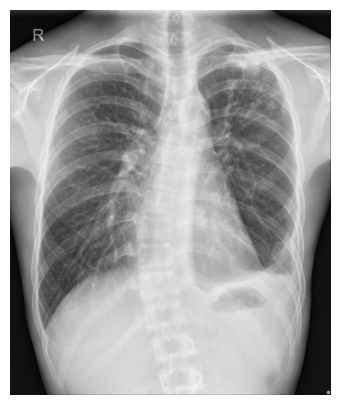

In [6]:
image = Image.open('/root/autodl-tmp/lung-segment/images/0.png')
image = np.array(image.convert("RGB"))
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

In [22]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/root/sam2/CXR/fold_0_finetuned_sam2.1.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

In [23]:
def predict_mask(predictor:SAM2ImagePredictor, points, labels, boxes, mask):
    # prompt encoding
    if points is not None:
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(points, labels), boxes=boxes,masks=mask)
    else:
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=None, boxes=boxes,masks=mask)

    #print(predictor._features["image_embed"].shape)
    # mask decoder
    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"],image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=False,repeat_image=False,high_res_features=high_res_features,)
    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution
    print(low_res_masks.min(), low_res_masks.max(), torch.median(low_res_masks), low_res_masks.shape)
    prd_mask = torch.sigmoid(prd_masks[:, 0]) # Turn logit map to probability map
    return low_res_masks, prd_mask, prd_scores

In [31]:
low_res_masks, prd_mask, prd_scores = predict_mask(predictor, None, None, None, None)
low_res_masks.shape, prd_mask, prd_scores

tensor(-17.3750, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MinBackward1>) tensor(10.1875, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(-4.3438, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<MedianBackward0>) torch.Size([1, 1, 256, 256])


(torch.Size([1, 1, 256, 256]),
 tensor([[[5.0937e-06, 5.0937e-06, 5.0937e-06,  ..., 1.8925e-05,
           1.8925e-05, 1.8925e-05],
          [5.0937e-06, 5.0937e-06, 5.0937e-06,  ..., 1.8925e-05,
           1.8925e-05, 1.8925e-05],
          [5.0937e-06, 5.0937e-06, 5.0937e-06,  ..., 1.8925e-05,
           1.8925e-05, 1.8925e-05],
          ...,
          [1.3007e-05, 1.3007e-05, 1.3007e-05,  ..., 7.0967e-04,
           7.0967e-04, 7.0967e-04],
          [1.3007e-05, 1.3007e-05, 1.3007e-05,  ..., 7.0967e-04,
           7.0967e-04, 7.0967e-04],
          [1.3007e-05, 1.3007e-05, 1.3007e-05,  ..., 7.0967e-04,
           7.0967e-04, 7.0967e-04]]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[0.9141]], device='cuda:0', dtype=torch.bfloat16,
        grad_fn=<WhereBackward0>))

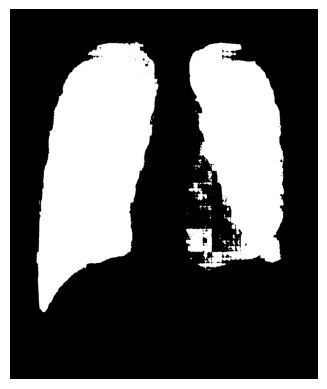

In [58]:
np_img = (prd_mask[0].float() > 0.5).cpu().detach().numpy()
plt.imshow(np_img, cmap='gray')
plt.axis("off")
plt.show()

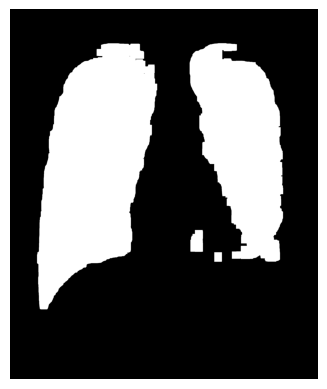

In [47]:
open_prd_mask = morphological_open(prd_mask.unsqueeze(1), 50)
np_img = (open_prd_mask[0][0].float() > 0.5).cpu().detach().numpy()
plt.imshow(np_img, cmap='gray')
plt.axis("off")
plt.show()

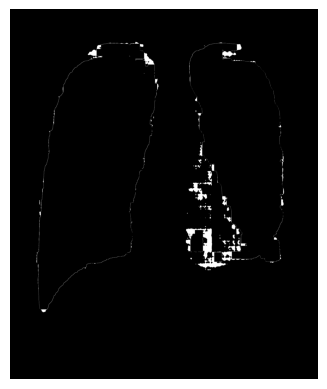

In [57]:
difference_map = ((open_prd_mask > 0.5) != (prd_mask > 0.5)).float().cpu().detach().numpy()
plt.imshow(difference_map[0][0], cmap='gray')
plt.axis("off")
plt.show()

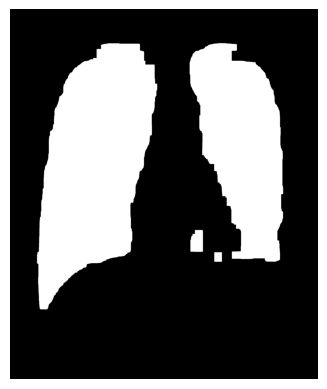

In [59]:
open_close_prd_mask = morphological_close(open_prd_mask, 75)
np_img = (open_close_prd_mask[0][0].float() > 0.5).cpu().detach().numpy()
plt.imshow(np_img, cmap='gray')
plt.axis("off")
plt.show()

torch.Size([1, 1, 2945, 2450]) torch.Size([1, 1, 2945, 2450]) torch.Size([1, 2945, 2450])


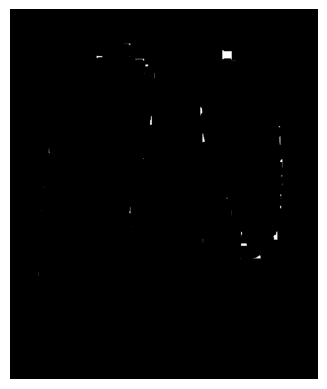

In [62]:
print(open_prd_mask.shape, open_close_prd_mask.shape, prd_mask.shape)
difference_map = ((open_prd_mask > 0.5) != (open_close_prd_mask > 0.5)).float().cpu().detach().numpy()
plt.imshow(difference_map[0][0], cmap='gray')
plt.axis("off")
plt.show()